In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import time

## Abstract:

Deep Neural networks seemed to be the answer to image classification. However, extremely deep networks, 100 plus layers, were not performing as well as one expects. Kaming hu's Residual neural network solved this problem. This offshoot of Highway Networks, the first successful 100-layer network,  vastly outperforms its predecessors in image classification. We shall use the CIFAR10 dataset, consisting of 10 classes and 60000 images distributed evenly to fit a 9 layers residual Neural Network. We will also see how a Wide Residual Neural Network improves on the original architecture.

## 1 Results:

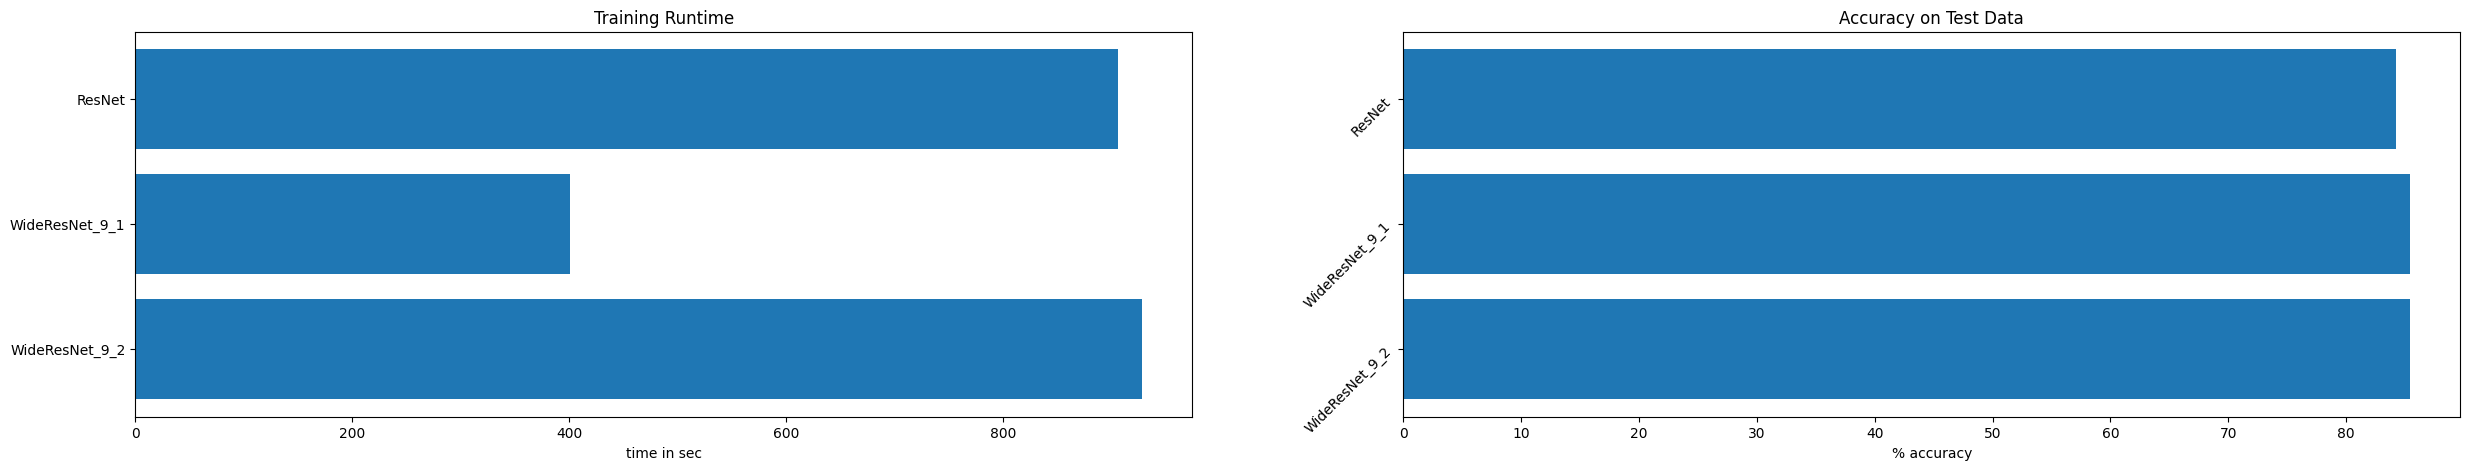

In [51]:

training_times = [resnet_dict['time'], 
                  wideresnet_dict['time'], 
                  wideresnet9_2_dict['time']]#, 
                  #wideresnet9_4_dict['time']]
labels = ['ResNet', 'WideResNet_9_1', 'WideResNet_9_2']#, 'wideresnet9_4']
y_pos = np.arange(len(training_times))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,5))

axes[0].barh(y_pos, training_times, align='center')
axes[0].set_yticks(y_pos, labels=labels)
axes[0].invert_yaxis()  # labels read top-to-bottom
axes[0].set_xlabel('time in sec')
axes[0].set_title('Training Runtime')


accuracies = [resnet_acc, wideresnet_acc, wideresnet9_2_acc]#, wideresnet9_4_acc]
y_pos = np.arange(len(training_times))



axes[1].barh(y_pos, accuracies, align='center')
axes[1].set_yticks(y_pos, labels=labels, rotation = 45)
axes[1].invert_yaxis()  # labels read top-to-bottom
axes[1].set_xlabel('% accuracy')
axes[1].set_title('Accuracy on Test Data')


plt.show()

#### 1.1 Discussion And Conclusion:

The models with wide residual blocks perform better. However, the accuracies given by these models do not necessarily justify the larger architecture. From Zagoruyko's paper on Wide residual Networks, it seems that these models prove their efficiency when constructed to be much deeper. Changing Hyper parameters such as the tolerance, as defined in the ModelTrainer function, and the learning rate might help these models perform better. We seek to study the effect of such parameters in further reports.

## 2 Data:

We use the CIFAR10 which consist of 10 calsses and 60000 images. This dataset was provided by the university of toronto: https://www.cs.toronto.edu/~kriz/cifar.html.
The classes used are:


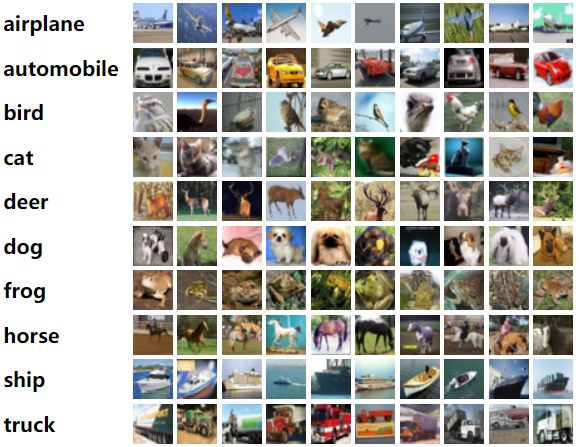


We transform the data into a tensor before nomalizing it.

In [2]:
## Getting Data:

transform = transforms.Compose([transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        transform=transform, download = True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       transform=transform, download = True)

testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## 3 Modeling:

#### 3.1 Training Function:

We define the model trainer as a function that takes in a model and a loss function. It trains the model and return the losses per epoch and the train time.

In [28]:
def ModelTrainer(model, loss_fct, epoch_num = 25, Tol = 0.05):
    '''
    Model: Model to train,
    loss_fct: Losses function to be used
    epoch_num: The number of epochs
    Tol: Minimal Loss to be achived before stopping.
    '''
    
    
    losses = [] ##register  epoch & loss
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    train_time = time.time()

    

    for epoch in range(epoch_num):  

        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):

            inputs, labels = data  
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)        

            loss = loss_fct(outputs, labels)
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
        losses +=[[epoch+1, running_loss / 6250]] 
        print('epoch : %d , loss = %.3f' % (epoch+1, running_loss / 6250))

        if (running_loss / 6250) < Tol:
            break
    train_time = time.time() - train_time
    return {'time': train_time, 'losses': losses, 'epochs': epoch_num}

#### 3.2 Accuracy Function:
We define the accuracy as the number of correct prediction of the test set defined in the data section.

In [29]:
def accuracy(model):
    
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)

    _, predicted = torch.max(outputs, 1)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy : %d %%' % (
        100 * correct / total))
    return 100 * correct / total

### 3.1 ResNet:

We use the architecture presented in https://www.kaggle.com/code/kmldas/cifar10-resnet-90-accuracy-less-than-5-min. It is a 9 layer block that follows the ResNet architechture:

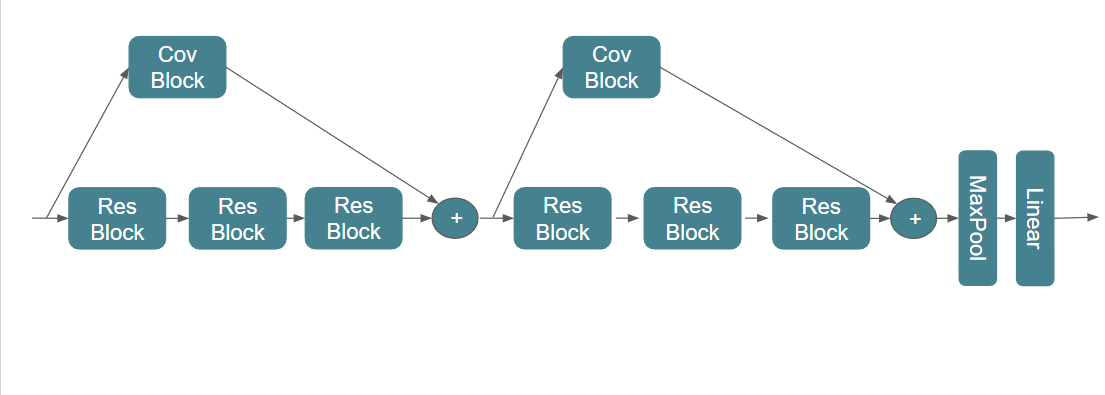

##### Residual Block:

Res Block refers to the residual block. It follows the architechture presented in Kaming hu's paper:

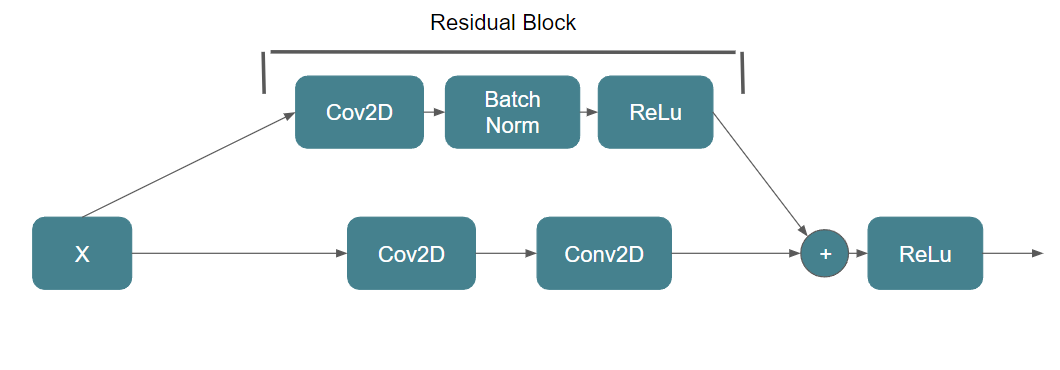

In [5]:
def Res_Block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    
    return nn.Sequential(*layers)



##### Resnet 9 layers Architecture:

In [6]:
class ResNet9(torch.nn.Module):
    def __init__(self, in_channels, num_classes=10):
        super().__init__()
        
        self.conv1 = Res_Block(in_channels, 64)
        self.conv2 = Res_Block(64, 128, pool=True)
        self.res1 = nn.Sequential(Res_Block(128, 128), 
                                  Res_Block(128, 128))
        
        self.conv3 = Res_Block(128, 256, pool=True)
        self.conv4 = Res_Block(256, 512, pool=True)
        self.res2 = nn.Sequential(Res_Block(512, 512), 
                                  Res_Block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
resnet = ResNet9(in_channels = 3)
resnet = resnet.to(device)

loss_fct = nn.CrossEntropyLoss()

resnet_dict = ModelTrainer(resnet, loss_fct)

epoch : 1 , loss = 1.848
epoch : 2 , loss = 0.898
epoch : 3 , loss = 0.660
epoch : 4 , loss = 0.523
epoch : 5 , loss = 0.430
epoch : 6 , loss = 0.342
epoch : 7 , loss = 0.283
epoch : 8 , loss = 0.221
epoch : 9 , loss = 0.186
epoch : 10 , loss = 0.159
epoch : 11 , loss = 0.143
epoch : 12 , loss = 0.117
epoch : 13 , loss = 0.100
epoch : 14 , loss = 0.094
epoch : 15 , loss = 0.078
epoch : 16 , loss = 0.077
epoch : 17 , loss = 0.071
epoch : 18 , loss = 0.065
epoch : 19 , loss = 0.052
epoch : 20 , loss = 0.056
epoch : 21 , loss = 0.053
epoch : 22 , loss = 0.047


In [8]:
resnet_acc = accuracy(resnet)

Accuracy : 84 %


### 3.2 Wide ResNet:

We now modify the Residual block to reflect Zagoruyko's wide residual network. We change the order of operation, starting with batch normalization, then Relu, and finally The convolution. We also increase the number of out channels by multiplying by a factor k.

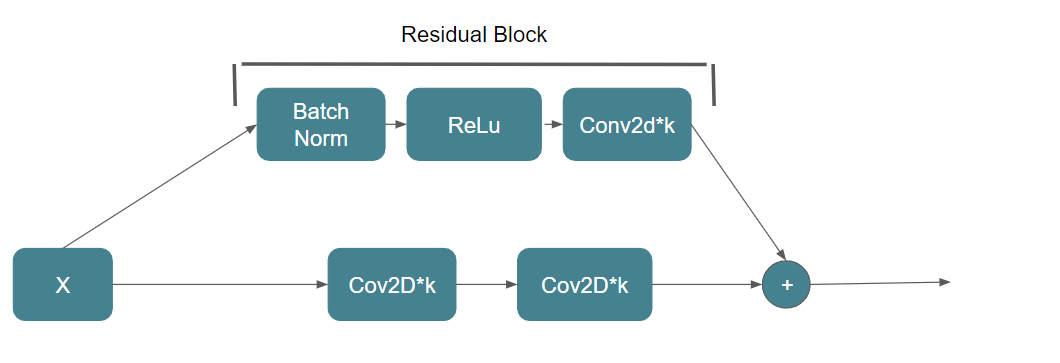

##### Wide Residual Block:

In [30]:
def Res_block_wide(in_channels, out_channels, k=1,  pool=False):
    layers = [
                nn.BatchNorm2d(in_channels), 
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels, k*out_channels, kernel_size=3, padding=1),
                # nn.Dropout(0.3, inplace=True)
        
              ]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)



##### Wide ResNet l = 9:

In [31]:
class WideResNet9(torch.nn.Module):
    def __init__(self, in_channels, k = 1,  num_classes=10):
        super().__init__()
        
        self.conv1 = Res_block_wide(in_channels, 64, k)
        self.conv2 = Res_block_wide(k*64, 128, k, pool=True)
        self.res1 = nn.Sequential(Res_block_wide(k*128, 128, k), 
                                  Res_block_wide(k*128, 128, k))
        
        self.conv3 = Res_block_wide(k*128, 256, k, pool=True)
        self.conv4 = Res_block_wide(k*256, 512, k, pool=True)
        self.res2 = nn.Sequential(Res_block_wide(k*512, 512, k), 
                                  Res_block_wide(k*512, 512, k))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(k*512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out

        out = self.classifier(out)
        return out

#### Wide Resnet l = 9 k = 1:
First we test the effect of the change in the order to see ho the new ordering of the Batch Normaalization, ReLu, and then Conv2D affects te accuracy alone.

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
wideresnet = WideResNet9(in_channels = 3)
wideresnet = wideresnet.to(device)

loss_fct = nn.CrossEntropyLoss()

wideresnet_dict = ModelTrainer(wideresnet, loss_fct, epoch_num = 10)

epoch : 1 , loss = 1.404
epoch : 2 , loss = 0.783
epoch : 3 , loss = 0.558
epoch : 4 , loss = 0.417
epoch : 5 , loss = 0.323
epoch : 6 , loss = 0.255
epoch : 7 , loss = 0.225
epoch : 8 , loss = 0.203
epoch : 9 , loss = 0.201
epoch : 10 , loss = 0.196


In [33]:
wideresnet_acc = accuracy(wideresnet)

Accuracy : 85 %


#### Wide ResNet l = 9 k = 2:

We now look at a model with double the depth of the residual block.

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
wideresnet9_2 = WideResNet9(in_channels = 3, k=2)
wideresnet9_2 = wideresnet9_2.to(device)

loss_fct = nn.CrossEntropyLoss()


wideresnet9_2_dict = ModelTrainer(wideresnet9_2, loss_fct, epoch_num = 10)

epoch : 1 , loss = 1.649
epoch : 2 , loss = 0.916
epoch : 3 , loss = 0.652
epoch : 4 , loss = 0.472
epoch : 5 , loss = 0.342
epoch : 6 , loss = 0.250
epoch : 7 , loss = 0.212
epoch : 8 , loss = 0.179
epoch : 9 , loss = 0.181
epoch : 10 , loss = 0.165


In [41]:
wideresnet9_2_acc = accuracy(wideresnet9_2)

Accuracy : 85 %
